## Project 1: Classification of ENSO extreme phases through SST data

## Data read + plotting NINO3.4

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

#nice figures
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['font.size'] = 12

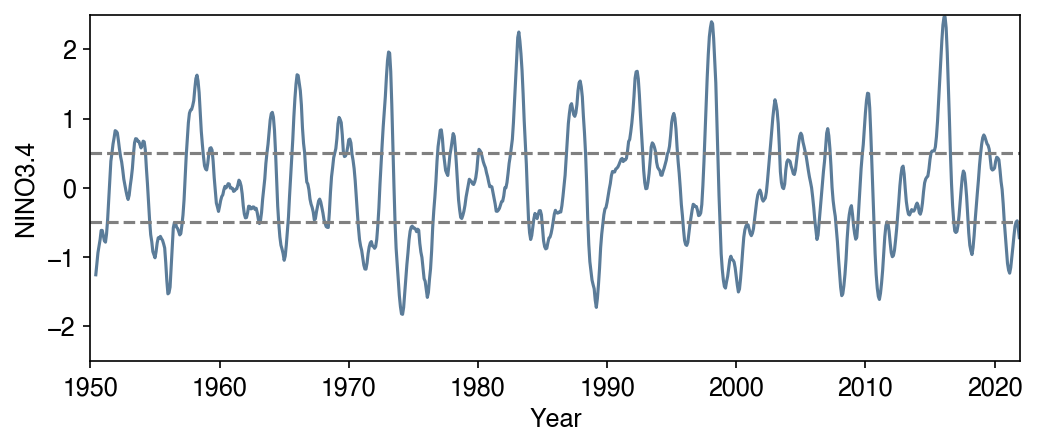

In [5]:

filename = "ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc"
sstds = xr.open_dataset(filename)
sst = sstds.sst
time = sstds.time

ninolat1 = -5
ninolat2 = 5
ninolon1 = 190
ninolon2 = 240

sstnino = np.asarray(sst.sel(lat=slice(ninolat1,ninolat2),lon=slice(ninolon1,ninolon2)))
nino34 = np.nanmean(sstnino,axis=(1,2))
timevec = np.arange(1950+(5/12),2022,1/12)

plt.figure(figsize=(8,3))
plt.plot(timevec,nino34,color='xkcd:slate blue')
plt.hlines(0.5,1950,2022,linestyle='dashed',color='grey')
plt.hlines(-0.5,1950,2022,linestyle='dashed',color='grey')
plt.xlim(1950,2022)
plt.ylim(-2.5,2.5)
plt.xlabel("Year")
plt.ylabel("NINO3.4")
plt.show()

In [ ]:
# Split data in La nina and el nino based on index assign labels, and discard 
#event if it doe snot fit either

In [ ]:
#divide into training and 